# Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD

# Data loading

In [3]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

## Layers testing
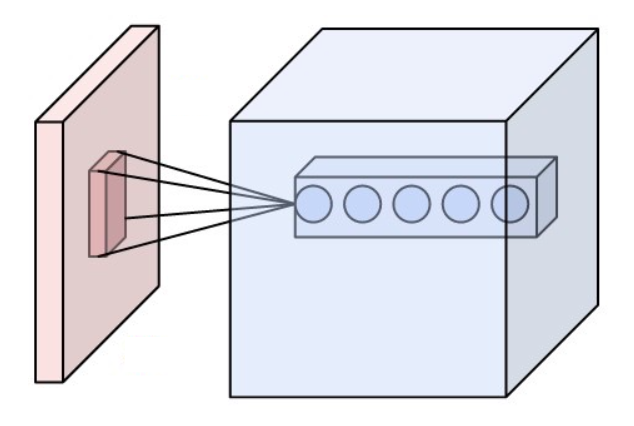

In [4]:
X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), "result: %s, X: %s" % (result, X[:, :1, :1, :1] + 1)


layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


### Backward pass

In [5]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


### Padding

In [6]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
assert result.shape == X.shape, "Result shape: %s - Expected shape %s" % (result.shape, X.shape)

d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

Gradient check passed!


### Max pooling

In [7]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)
assert check_layer_gradient(pool, X)

Gradient check passed!


### Flattener

In [8]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)
assert check_layer_gradient(flattener, X)

Gradient check passed!


## Model

In [9]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for conv1_W
Gradient check passed!
Checking gradient for conv1_B
Gradient check passed!
Checking gradient for conv2_W
Gradient check passed!
Checking gradient for conv2_B
Gradient check passed!
Checking gradient for fc_W
Gradient check passed!
Checking gradient for fc_B
Gradient check passed!


True

# Optimizer and training

In [10]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-3)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.302902, Train accuracy: 0.000000, val accuracy: 0.125000
Loss: 2.302174, Train accuracy: 0.062500, val accuracy: 0.125000
Loss: 2.301447, Train accuracy: 0.062500, val accuracy: 0.125000
Loss: 2.300722, Train accuracy: 0.062500, val accuracy: 0.250000
Loss: 2.299997, Train accuracy: 0.187500, val accuracy: 0.250000
Loss: 2.299274, Train accuracy: 0.250000, val accuracy: 0.250000
Loss: 2.298552, Train accuracy: 0.187500, val accuracy: 0.187500
Loss: 2.297831, Train accuracy: 0.187500, val accuracy: 0.187500
Loss: 2.297111, Train accuracy: 0.125000, val accuracy: 0.187500
Loss: 2.296392, Train accuracy: 0.125000, val accuracy: 0.187500
Loss: 2.295675, Train accuracy: 0.125000, val accuracy: 0.187500
Loss: 2.294958, Train accuracy: 0.187500, val accuracy: 0.187500
Loss: 2.294243, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.293529, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.292816, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.292104, Train acc

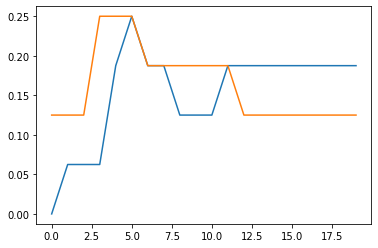

In [11]:
plt.plot(loss_history)
plt.plot(train_history)
plt.plot(val_history)

## Overfitting test

In [24]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=64, conv2_channels=128)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(momentum=0.99), learning_rate=1e-5, num_epochs=50, batch_size=32)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.611768, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.392708, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 3.223216, Train accuracy: 0.195312, val accuracy: 0.210938
Loss: 2.333515, Train accuracy: 0.171875, val accuracy: 0.093750
Loss: 2.238316, Train accuracy: 0.203125, val accuracy: 0.265625
Loss: 2.241359, Train accuracy: 0.171875, val accuracy: 0.101562
Loss: 2.374145, Train accuracy: 0.210938, val accuracy: 0.132812
Loss: 1.901433, Train accuracy: 0.296875, val accuracy: 0.234375
Loss: 2.116448, Train accuracy: 0.328125, val accuracy: 0.093750
Loss: 1.628478, Train accuracy: 0.328125, val accuracy: 0.234375
Loss: 1.676217, Train accuracy: 0.445312, val accuracy: 0.140625
Loss: 1.665798, Train accuracy: 0.445312, val accuracy: 0.140625
Loss: 1.498056, Train accuracy: 0.492188, val accuracy: 0.171875
Loss: 1.511524, Train accuracy: 0.476562, val accuracy: 0.156250
Loss: 1.385151, Train accuracy: 0.578125, val accuracy: 0.148438
Loss: 1.355818, Train acc

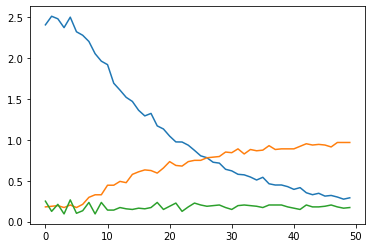

In [25]:
plt.plot(loss_history)
plt.plot(train_history)
plt.plot(val_history)
